# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [4]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [5]:
DATA_PATH = 'cifar_data'
NUM_TRAIN = 450 # Lowering the data as it takes a looooooong time to execute for the purposes of the activity.
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)

test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

### Usar GPU

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Mostrar imágenes

La imagen muestreada representa un: Ship


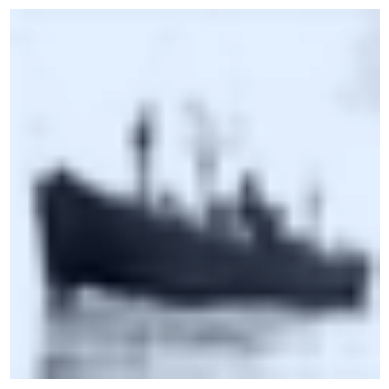

In [7]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [ ]:
def accuracy(model, loader):
    model.eval()
    num_correct = 0
    num_total = 0

    with torch.inference_mode():
        print(f'Running for {len(loader)} iterations...')
        for i , (xi, yi) in enumerate(loader):
            xi = xi.to(device, non_blocking=True, dtype=torch.float32)
            yi = yi.to(device, non_blocking=True, dtype=torch.long)

            scores = model(xi)
            pred = scores.argmax(dim=1)
            num_correct += (pred == yi).sum().item()
            num_total += yi.size(0)
            print(f'For loop #{i+1}, num correct: {num_correct}, num total: {num_total}')

    return num_correct / num_total


### Cargar modelo pre-cargado

In [9]:
model_resnet18 = models.resnet18(pretrained=True)

/Users/cesarivp/Documents/GitHub/pedreros_advanced_machine_learning/advanced_machine_learning/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cesarivp/Documents/GitHub/pedreros_advanced_machine_learning/advanced_machine_learning/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Exploremos el modelo

In [10]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [11]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [13]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

### Loop de entrenamiento

In [15]:
def train(model, optimiser, epochs):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()

        print(f'Epoch: {epoch+1}, costo: {cost.item()}')

In [78]:
# Constants across all the models:
hidden1 = 256 
hidden = 256
lr = 5e-4

In [ ]:
epochs = 30

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [17]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
train(model1, optimiser, epochs)

Epoch: 1, costo: 2.280834197998047
Epoch: 2, costo: 2.343249559402466
Epoch: 3, costo: 2.3290977478027344
Epoch: 4, costo: 2.287856101989746
Epoch: 5, costo: 2.074223279953003
Epoch: 6, costo: 2.734856605529785
Epoch: 7, costo: 2.6475582122802734
Epoch: 8, costo: 2.3603317737579346
Epoch: 9, costo: 1.9131646156311035
Epoch: 10, costo: 1.4336377382278442
Epoch: 11, costo: 2.0748701095581055
Epoch: 12, costo: 1.2357994318008423
Epoch: 13, costo: 2.253140449523926
Epoch: 14, costo: 2.1432926654815674
Epoch: 15, costo: 2.111727714538574
Epoch: 16, costo: 2.1327571868896484
Epoch: 17, costo: 1.5127336978912354
Epoch: 18, costo: 1.6584428548812866
Epoch: 19, costo: 1.7156975269317627
Epoch: 20, costo: 1.3659361600875854
Epoch: 21, costo: 1.0266039371490479
Epoch: 22, costo: 1.6802127361297607
Epoch: 23, costo: 1.9868299961090088
Epoch: 24, costo: 0.9922352433204651
Epoch: 25, costo: 1.7043118476867676
Epoch: 26, costo: 1.5431679487228394
Epoch: 27, costo: 2.05358624458313
Epoch: 28, costo: 1

In [17]:
accuracy(model1, test_loader)

157
For loop #1, num correct: 42, num total: 64
For loop #2, num correct: 79, num total: 128
For loop #3, num correct: 114, num total: 192
For loop #4, num correct: 151, num total: 256
For loop #5, num correct: 195, num total: 320
For loop #6, num correct: 235, num total: 384
For loop #7, num correct: 269, num total: 448
For loop #8, num correct: 304, num total: 512
For loop #9, num correct: 351, num total: 576
For loop #10, num correct: 390, num total: 640
For loop #11, num correct: 432, num total: 704
For loop #12, num correct: 475, num total: 768
For loop #13, num correct: 518, num total: 832
For loop #14, num correct: 559, num total: 896
For loop #15, num correct: 599, num total: 960
For loop #16, num correct: 649, num total: 1024
For loop #17, num correct: 692, num total: 1088
For loop #18, num correct: 732, num total: 1152
For loop #19, num correct: 772, num total: 1216
For loop #20, num correct: 807, num total: 1280
For loop #21, num correct: 850, num total: 1344
For loop #22, n

0.6304

### Segundo modelo pre entrenado: AlexNet
--- 

In [19]:
model_alexnet = models.alexnet(pretrained = True)

/Users/cesarivp/Documents/GitHub/pedreros_advanced_machine_learning/advanced_machine_learning/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/cesarivp/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


In [20]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model_aux_alex_net = nn.Sequential(*list(model_alexnet.children()))
model_aux_alex_net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplac

In [22]:
model_aux_alex_net = nn.Sequential(*list(model_alexnet.children())[:-1])
model_aux_alex_net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [23]:
for i, parameter in enumerate(model_aux_alex_net.parameters()):
    parameter.requires_grad = False

In [ ]:
epochs = 30

model2 = nn.Sequential(model_aux_alex_net,
                       nn.Flatten(), 
                       nn.Linear(in_features=9216, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.999))

In [29]:
model2

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=9216, out_features=10

In [30]:
train(model2, optimiser, epochs)

Epoch: 1, costo: 1.6239595413208008
Epoch: 2, costo: 0.5183233022689819
Epoch: 3, costo: 0.27755093574523926
Epoch: 4, costo: 0.11134657263755798
Epoch: 5, costo: 0.25364118814468384
Epoch: 6, costo: 0.07104162126779556
Epoch: 7, costo: 0.019000517204403877
Epoch: 8, costo: 0.04475570470094681
Epoch: 9, costo: 0.05660790577530861
Epoch: 10, costo: 0.050396502017974854
Epoch: 11, costo: 0.018701568245887756
Epoch: 12, costo: 0.011148343794047832
Epoch: 13, costo: 0.034784793853759766
Epoch: 14, costo: 0.0395420677959919
Epoch: 15, costo: 0.0099954130128026
Epoch: 16, costo: 0.010401735082268715
Epoch: 17, costo: 0.007162910886108875
Epoch: 18, costo: 0.012636631727218628
Epoch: 19, costo: 0.006822539959102869
Epoch: 20, costo: 0.0075976913794875145
Epoch: 21, costo: 0.000920591875910759
Epoch: 22, costo: 0.02020709216594696
Epoch: 23, costo: 0.015637287870049477
Epoch: 24, costo: 0.010803643614053726
Epoch: 25, costo: 0.002622321480885148
Epoch: 26, costo: 0.007451730314642191
Epoch: 27

In [31]:
accuracy(model2, test_loader)

157
For loop #1, num correct: 45, num total: 64
For loop #2, num correct: 88, num total: 128
For loop #3, num correct: 127, num total: 192
For loop #4, num correct: 168, num total: 256
For loop #5, num correct: 214, num total: 320
For loop #6, num correct: 257, num total: 384
For loop #7, num correct: 303, num total: 448
For loop #8, num correct: 350, num total: 512
For loop #9, num correct: 392, num total: 576
For loop #10, num correct: 439, num total: 640
For loop #11, num correct: 482, num total: 704
For loop #12, num correct: 526, num total: 768
For loop #13, num correct: 565, num total: 832
For loop #14, num correct: 606, num total: 896
For loop #15, num correct: 652, num total: 960
For loop #16, num correct: 701, num total: 1024
For loop #17, num correct: 743, num total: 1088
For loop #18, num correct: 781, num total: 1152
For loop #19, num correct: 825, num total: 1216
For loop #20, num correct: 860, num total: 1280
For loop #21, num correct: 900, num total: 1344
For loop #22, n

0.6754

### Tercer modelo pre entrenado: Densenet161
--- 

In [69]:
model_densenet161 = models.densenet161(pretrained = True)

/Users/cesarivp/Documents/GitHub/pedreros_advanced_machine_learning/advanced_machine_learning/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
model_densenet161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [71]:
model_aux_densenet161 = nn.Sequential(*list(model_densenet161.children()))
model_aux_densenet161

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): 

In [72]:
model_aux_densenet161 = nn.Sequential(*list(model_densenet161.children())[:-1])
model_aux_densenet161

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): 

In [73]:
for i, parameter in enumerate(model_aux_densenet161.parameters()):
    parameter.requires_grad = False

In [ ]:
epochs = 7

model3 = nn.Sequential(model_aux_densenet161,
                       nn.Flatten(), 
                       nn.Linear(in_features=108192, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model3.parameters(), lr=lr, betas=(0.9, 0.999))

In [75]:
model3

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affin

In [76]:
train(model3, optimiser, epochs)

Epoch: 1, costo: 4.172379493713379
Epoch: 2, costo: 1.0120171308517456
Epoch: 3, costo: 0.014635697938501835
Epoch: 4, costo: 0.03204665333032608
Epoch: 5, costo: 1.425402283668518
Epoch: 6, costo: 1.311300479756028e-06
Epoch: 7, costo: 0.0017386515391990542


In [77]:
accuracy(model3, test_loader)

157
For loop #1, num correct: 41, num total: 64
For loop #2, num correct: 81, num total: 128
For loop #3, num correct: 118, num total: 192
For loop #4, num correct: 156, num total: 256
For loop #5, num correct: 198, num total: 320
For loop #6, num correct: 241, num total: 384
For loop #7, num correct: 285, num total: 448
For loop #8, num correct: 326, num total: 512
For loop #9, num correct: 367, num total: 576
For loop #10, num correct: 409, num total: 640
For loop #11, num correct: 447, num total: 704
For loop #12, num correct: 497, num total: 768
For loop #13, num correct: 536, num total: 832
For loop #14, num correct: 575, num total: 896
For loop #15, num correct: 618, num total: 960
For loop #16, num correct: 662, num total: 1024
For loop #17, num correct: 705, num total: 1088
For loop #18, num correct: 750, num total: 1152
For loop #19, num correct: 798, num total: 1216
For loop #20, num correct: 841, num total: 1280
For loop #21, num correct: 885, num total: 1344
For loop #22, n

0.6773

- Modified the original function because it took way too long for ths activity purposes, lowering training times from 4hrs to 15 minutes per each model. Main changes:
  - Removed accuracy computing on each for with the validation in the second for of the training function. We only printed the value, not doing anything with it.
  - Lowered the trainig data to 450. We didnt modified the testing length. Even so, we achieved more than 63% on all the models.

- The last model we trained only on 7 epochs, as it was pretty big, instead of the standard 30 for the other ones. This was enough for a 67% accuracy.